In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd
from numpy.linalg import inv
from scipy import optimize
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.stats import rv_discrete
from matplotlib import pyplot as plt
from numpy.random import default_rng

In [2]:
from qiskit import QuantumCircuit, pulse, circuit, transpile, assemble, schedule
from qiskit.circuit import Gate
from qiskit.tools.monitor import job_monitor
from qiskit.pulse.library import GaussianSquare
from qiskit.providers.fake_provider import FakeAthens, FakeBoeblingenV2, FakeOpenPulse2Q


from qiskit import assemble
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [3]:
def makepath(path):
    now = datetime.datetime.now()
    now = now.strftime('%Y_%m_%d__%H_%M_%S')
    now = str(now)
    path_now = os.path.join(path, now)
    if not os.path.exists(path_now):
        os.makedirs(path_now)
    print("figs saved in: {}".format(path_now))
    return path_now


def accept_rej(f, x, N):
    idx = np.arange(len(x))
    q_sample = rv_discrete(name='q_sample', values=(idx, f))
    sample_idx = q_sample.rvs(size=N)
    return x[sample_idx]


def complex2idx(original, cplx):
    return np.array([np.where(np.isin(original, cplx[i])) for i in range(len(cplx))]).reshape(len(cplx))


def build_query_circuit(U, M, t, cr_sched, ctrl_bit, tar_bit):
    cr_gate = circuit.Gate("cr", num_qubits=1, params=[])
    sim_circuit = QuantumCircuit(2,1)
    if U == 1:
        sim_circuit.x(ctrl_bit)
    sim_circuit.append(cr_gate, [ctrl_bit])
    sim_circuit.barrier()
    if M == 0:
        sim_circuit.ry(np.pi/4, tar_bit)
    elif M == 1:
        sim_circuit.rx(-np.pi/4, tar_bit)
    sim_circuit.barrier()
    sim_circuit.add_calibration(cr_gate, [ctrl_bit], cr_sched)
    sim_circuit.measure(tar_bit, 0)
    return sim_circuit


def build_cr_echo_schedule(query, amp, rise_ratio, backend, q_c, q_t):
    inst_sched_map = backend.defaults().instruction_schedule_map
    x_pulse = inst_sched_map.get("x", (q_c))
    with pulse.build(backend=backend) as cr_sched:
        ctrl_chan = pulse.control_channels(q_c, q_t)[0]
        dr_ct_chan = pulse.drive_channel(q_c)
        pulse.play(GaussianSquare(int(query[-1]), amp, int(np.min([query[-1]*rise_ratio, 30])), risefall_sigma_ratio=1), ctrl_chan)
        # pulse.play([amp]*int(query[-1]//2), ctrl_chan)
        pulse.barrier(ctrl_chan, dr_ct_chan)
        pulse.call(x_pulse)
        pulse.barrier(ctrl_chan, dr_ct_chan)
        # pulse.play([-1*amp]*int(query[-1]//2), ctrl_chan)
        pulse.play(GaussianSquare(int(query[-1]), -1*amp, int(np.min([query[-1]*rise_ratio, 30])), risefall_sigma_ratio=1), ctrl_chan)

    circuit = build_query_circuit(*query, cr_sched, q_c, q_t)
    sim_transpiled = transpile(circuit, backend)        
    return schedule(sim_transpiled, backend)


def build_cr_schedule(amp, query, backend, rise_ratio=0.1, q_c=1, q_t=0):
    ct_bit = q_c
    tar_bit = q_t
    with pulse.build(backend=backend) as cr_sched:
        ctrl_chan_01 = pulse.control_channels(ct_bit, tar_bit)[0]
        pulse.play(GaussianSquare(int(query[-1]), amp, int(np.min([query[-1]*rise_ratio, 30])), risefall_sigma_ratio=1), ctrl_chan_01)
        # pulse.play([amp]*int(query[-1]), ctrl_chan_01)
    circuit = build_query_circuit(*query, cr_sched, ct_bit, tar_bit)
    sim_transpiled = transpile(circuit, backend)
    return schedule(sim_transpiled, backend)

def mean_duplicate(data, cols=["t", "U"], is_duplicated=True, is_second=False):
    if is_duplicated:
        data_unique = data[(data[cols].duplicated(keep=False)==False)].reset_index(drop=True)
        data_dup = data[(data[cols].duplicated(keep=False)==True)].reset_index(drop=True)
        data_mean = data_dup.groupby(["t","U"]).mean().reset_index()
        if is_second:
            data_nan = data.loc[data["delta0"].isna()==True]
            return pd.concat([data_unique, data_mean, data_nan], join="inner").reset_index(drop=True)
        else:
            return pd.concat([data_unique, data_mean], join="inner").reset_index(drop=True)
    else:
        return data

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def rabi_oszillation(t, omega, delta):
    return 1-2*np.cos(delta)**2*np.sin(omega*t)**2


def fisher_infromation_matrix(t, omega_0, delta_0, omega_1, delta_1):
    A_0 = 4*t**2*np.cos(delta_0)**4*np.sin(2*omega_0*t)**2
    B_0 = -16*t**2*np.cos(delta_0)**3*np.sin(delta_0)*np.sin(omega_0*t)*np.cos(omega_0*t)
    C_0 = B_0
    D_0 = 16*np.cos(delta_0)**2*np.sin(delta_0)**2
    norm_0 = 1- (1-2*np.cos(delta_0)**2*np.sin(omega_0*t)**2)
    I_0 = np.array([[A_0, B_0], [C_0, D_0]])
    A_1 = 4*t**2*np.cos(delta_1)**4*np.sin(2*omega_1*t)**2
    B_1 = -16*t**2*np.cos(delta_1)**3*np.sin(delta_1)*np.sin(omega_1*t)*np.cos(omega_1*t)
    C_1 = B_1
    D_1 = 16*np.cos(delta_1)**2*np.sin(delta_1)**2
    norm_1 = 1- (1-2*np.cos(delta_1)**2*np.sin(omega_1*t)**2)
    I_1 = np.array([[A_1, B_1], [C_1, D_1]])

    if t != 0:
        return (np.kron(np.array([[0,0],[0,1]]), I_1) + np.kron(np.array([[1,0],[0,0]]), I_1))/(norm_0+norm_1)
    else:
        return np.eye(4)

def generate_fi_matrix(data, omega_0, delta_0, omega_1, delta_1):
    N_batch = data.shape[0]
    data.loc[data["U"]==0, "delta0"] = delta_0
    data.loc[data["U"]==1, "delta1"] = delta_1
    data.loc[data["U"]==0, "omega0"] = omega_0
    data.loc[data["U"]==1, "omega1"] = omega_1
    return np.array([fisher_infromation_matrix(data["t"].iloc[N], data["omega0"].iloc[N], data["delta0"].iloc[N], data["omega1"].iloc[N], data["delta1"].iloc[N]) for N in range(N_batch)])
    


def inv_weight_mat(weight, mat):
    weighted_mat = np.sum([abs(weight[i])*mat[i] for i in range(mat.shape[0])], axis=0)
    return np.trace(inv(weighted_mat))




def rabi_x(t, mu, eta, nu):
    alpha = np.arctan(np.sin(nu)/(np.cos(nu)*np.sin(eta)))
    return np.sin(2*eta)*np.cos(nu)/2+np.cos(eta)*np.sqrt(1-np.cos(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t+alpha)
    # return np.cos(eta)*np.sqrt(1-np.cos(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t+alpha)

def rabi_y(t, mu, eta, nu):
    gamma = np.arctan(np.cos(nu)/(np.sin(nu)*np.sin(eta)))
    return np.sin(2*eta)*np.sin(nu)/2-np.cos(eta)*np.sqrt(1-np.sin(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t-gamma)
    # return np.cos(eta)*np.sqrt(1-np.sin(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t+gamma)

def rabi_z(t, mu, eta, nu):
    return 1-2*np.cos(eta)**2*np.sin(mu*t)**2

In [4]:
""""""""""""""""""""""""
"""  Programm Start  """
""""""""""""""""""""""""
path = "C:\\Physics_Master\\Master_Arbeit\\figs"
use_full = False
# path = makepath(path)

# use fake athens as the backend
backend = FakeAthens()
default = backend.defaults()

# use pulse simulator to simulate the pulse
backend_model= PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator()
qubit_lo_freq = backend_model.hamiltonian.get_qubit_lo_from_drift()

default = backend.defaults()
inst_sched_map = default.instruction_schedule_map 

dt = backend.configuration().dt
print(dt)


C:\Users\tonny\AppData\Local\Temp\ipykernel_19436\2313674588.py:14: DeprecationWarning: The Pulse simulator backend in Qiskit Aer is deprecated and will be removed in a future release. Instead the qiskit-dynamics library should be used instead for simulating at the pulse level.
  backend_sim = PulseSimulator()


2.2222222222222221e-10


In [5]:

def cr_echo_pulse(n_t, amp, rise_ratio, backend, q_c, q_t):
    inst_sched_map = backend.defaults().instruction_schedule_map
    x_pulse = inst_sched_map.get("x", (q_c))
    with pulse.build(backend=backend) as cr_sched:
        ctrl_chan = pulse.control_channels(q_c, q_t)[0]
        dr_ct_chan = pulse.drive_channel(q_c)
        pulse.play(GaussianSquare(int(n_t//2), amp, int(n_t*rise_ratio), risefall_sigma_ratio=1), ctrl_chan)
        # pulse.play([amp]*n_t, ctrl_chan)
        # pulse.play(GaussianSquare(int(100), 0.5+0j, int(100*0.2), risefall_sigma_ratio=1), ctrl_chan_01)
        pulse.barrier(ctrl_chan, dr_ct_chan)
        pulse.call(x_pulse)
        pulse.barrier(ctrl_chan, dr_ct_chan)
        # pulse.play([-1*amp]*n_t, ctrl_chan)
        # pulse.play(GaussianSquare(int(100), 0.5+0j, int(100*0.2), risefall_sigma_ratio=1), ctrl_chan_01)
        pulse.play(GaussianSquare(int(n_t//2), -1*amp, int(n_t*rise_ratio), risefall_sigma_ratio=1), ctrl_chan)
        return cr_sched
sched = cr_echo_pulse(120, 0.3+0j, 0.1,backend, 1, 0)
# sched.draw(backend=backend)
# sched

In [6]:

"""
Init Query distribution
"""

t_max = 10*1e-7
N_t = 100
sig = 30
ts = (np.linspace((4*sig)*dt, t_max, N_t)/dt).astype(int)
Us = [0,1]
Ms = [0,1,2]
N_UM = len(Us)*len(Ms)
UMs = np.zeros((N_UM,), dtype=object)
for i in range(len(Us)):
    for j in range(len(Ms)):  
        UMs[i*(len(Us)+1)+j]=np.array([Us[i], Ms[j]])   
dist_tUM = np.ones((N_UM, N_t))
dist_tUM = dist_tUM/dist_tUM.size


x = np.zeros((N_UM, N_t, 3), dtype=object)
q = np.zeros((N_UM, N_t), dtype=float)

for i in range(N_UM):
    for j in range(N_t):
        x[i,j,0] = UMs[i][0]
        x[i,j,1] = UMs[i][1]
        x[i,j,2] = ts[j]
        q[i,j] = dist_tUM[i,j]

U_label= [r"$(U_0, X)$",r"$(U_0, Y)$",r"$(U_0, Z)$",r"$(U_1, X)$",r"$(U_1, Y)$",r"$(U_1, Z)$"]
fake_UM = np.arange(N_UM)

# plt.figure()
# plt.pcolormesh(ts*dt*1e9, fake_UM, q, cmap="Blues")
# plt.colorbar()
# plt.yticks(fake_UM, labels=U_label)
# plt.ylabel('U')
# plt.xlabel('t(dt)')
# plt.title(r'Starting Distribution of the Query $N_b$')
# plt.show()

In [7]:
# N_sample_query=30

# querytest = accept_rej(q.reshape((q.size,)), x.reshape((q.size,3)), N_sample_query)
N_sample_query = N_UM*N_t
querytest = x.reshape((N_UM*N_t, 3))

xq = np.array([querytest[:,0], querytest[:,1]]).T.reshape((N_sample_query,2))
# yq = 

UM_complex = (np.meshgrid(Us,Ms)[0]+1j*np.meshgrid(Us,Ms)[1]).T.reshape(N_UM,)

data = pd.DataFrame()
data["U"] = querytest[:,0].astype(int)
data["M"] = querytest[:,1].astype(int)
data["t"] = querytest[:,2].astype(int)
data["UM"] = data["U"]+1j*data["M"]
UMidx = complex2idx(UM_complex, data["UM"])


H, xedges, yedges = np.histogram2d(data["t"]*dt*1e9, UMidx, bins=[N_t, N_UM])
H = H.T

# binwidth = (N_UM-1)/N_UM/2
# fake_UM = np.linspace(1, N_UM*2-1, N_UM)*binwidth

# plt.figure()
# colormesh = plt.pcolormesh(xedges, yedges, H, cmap=discrete_cmap(int(np.max(H)+1), "Blues"))
# plt.colorbar(colormesh, ticks=range(int(np.max(H)+1)))
# plt.clim(-0.5, int(np.max(H)+1) - 0.5)
# plt.yticks(fake_UM, labels=U_label)
# plt.ylabel('U')
# plt.xlabel('t (ns)')
# plt.title(r'2D Histogramm Sampling Query with $N_b$={}'.format(N_sample_query))
# plt.show()

In [8]:
if use_full == True:
    path = "C:\Physics_Master\Master_Arbeit\HAL_demo\hal_simulation\FakeAthenSimulation\\full_to\\"
    data = []
    for i in range(len(UMs)):
        dataname = "full_U{}_M{}.csv".format(UMs[i][0], UMs[i][1])
        data.append(pd.read_csv(path+dataname, index_col=0))

In [9]:
# pulse_schedule = build_cr_echo_schedule(querytest[9], 0.5+0j, 0.1, backend, 1, 0)
# pulse_schedule.draw(backend=backend)

In [10]:
"""
Start first Measurement
"""
num_shots = 1024

counts = np.zeros(N_sample_query)

if use_full != True:
    for i in range(N_sample_query):
        """
        query format (U, M, t)
        """
        query = querytest[i]
        if query[2] == 0:
            counts[i] = 0
        else:
            pulse_schedule = build_cr_schedule(
                amp= 0.5+0j,
                query=query,
                backend=backend,
                rise_ratio=0.1,
                q_c=1,
                q_t=0
            )
            # pulse_schedule = build_cr_echo_schedule(query, 0.5+0j, 0.1, backend, 1, 0)
                                                    
            test_qobj = assemble(pulse_schedule,
                                backend = backend_sim,
                                qubit_lo_freq = qubit_lo_freq,
                                meas_level = 1, 
                                meas_return = 'avg',
                                shots = num_shots)

            result = backend_sim.run(test_qobj, system_model=backend_model).result()
            # counts of the 1 in the simulation
            counts[i] = np.real(result.get_memory(0)[0])

    data["count"] = 1-2*counts

    #postprocess
    is_dup = np.sum(data[["t","U"]].duplicated())
    data_filtered = mean_duplicate(data, ["t","U"], is_dup)

In [11]:
if use_full==True:
    sorted_data = data
else:
    sorted_data = [data.loc[data["UM"]==UM_complex[i]].sort_values(by="t") for i in range(N_UM)]

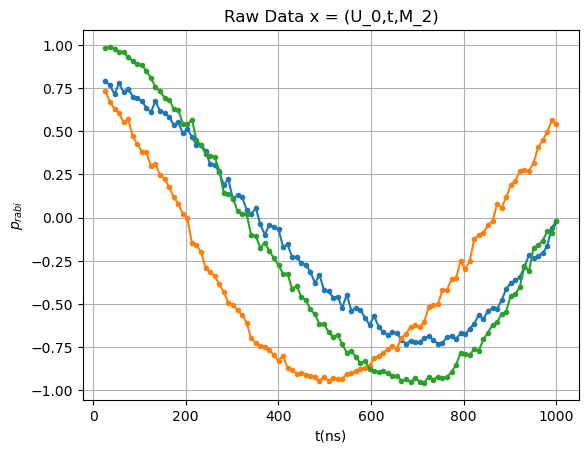

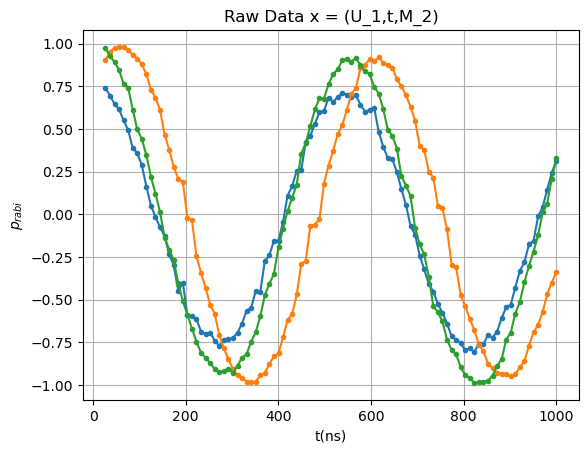

In [12]:
for i in range(N_UM):
    # print(UMs[i])
    if i%3 == 0:
        plt.figure()
    plt.plot(sorted_data[i]["t"]*dt*1e9, sorted_data[i]["count"], ".-")
    plt.xlabel("t(ns)")
    plt.ylabel(r"$p_{rabi}$")
    plt.title(r'Raw Data x = (U_{0},t,M_{1})'.format(*UMs[i]))
    plt.grid()
    # plt.show()

Fitting Paper

Transform parameters

### Save data


In [13]:
for i in range(len(sorted_data)):
    sel_data = sorted_data[i].reset_index()
    sel_data.to_csv("C:\Arbeit\\FakeAthenSimulation\\experiment_data\\single\\c1t0_05amp_30sig_rr01\\full_U{}_M{}.csv".format(sel_data["U"][0], sel_data["M"][0]))